In [1]:

import numpy as np
import geopandas as gpd

import rasterio
from rasterio.features import rasterize
from rasterio.plot import reshape_as_image
from rasterio.warp import calculate_default_transform, reproject

import folium
from folium.plugins import HeatMap
from folium.raster_layers import WmsTileLayer, ImageOverlay

import matplotlib.pyplot as plt
from PIL import Image
import tempfile

from tqdm import tqdm
from utils import vector_to_heatmap_overlay

In [89]:
GEOSERVER_URL = "https://sparcal.sdsc.edu/geoserver/rrk_sn/wms?"

# directory information for local data
DATA_DIR = "data/"
UTILS_DIR = "utils/"
SN_DIR = DATA_DIR + "sierra_nevada/"

IGNITION_PATH = SN_DIR + "sierra_nevada_fire_ignitions.geojson"
PERIMETER_PATH = SN_DIR + "sierra_nevada_fire_perimeters.geojson"
UTILITY_PATH = SN_DIR + "sierra_nevada_utility_lines.geojson"

SN_SHAPE_PATH = UTILS_DIR + "sierra_nevada_boundary.geojson"
SN_SHAPE = gpd.read_file(SN_SHAPE_PATH).to_crs(epsg=4326)['geometry']
#SN_SHAPE_5070 = gpd.read_file(SN_SHAPE_PATH).to_crs(epsg=5070).loc[0, 'geometry']

In [88]:
gpd.read_file(SN_SHAPE_PATH).crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Fire/Utility Data


In [3]:
ignition_df = gpd.read_file(IGNITION_PATH)#.to_crs(epsg=4326)
perimeter_df = gpd.read_file(PERIMETER_PATH)#.to_crs(epsg=4326)
utility_df = gpd.read_file(UTILITY_PATH)#.to_crs(epsg=4326)
buffered_ignition = gpd.read_file(IGNITION_PATH).buffer(500)#.to_crs(epsg=4326)

/opt/anaconda3/envs/wired-utility/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


width: 1831 , height: 5451 , 300 meters per pixel


100%|██████████| 52/52 [00:02<00:00, 20.08it/s]


width: 1831 , height: 5451 , 300 meters per pixel


 20%|██        | 821/4043 [00:21<01:26, 37.46it/s]


KeyboardInterrupt: 

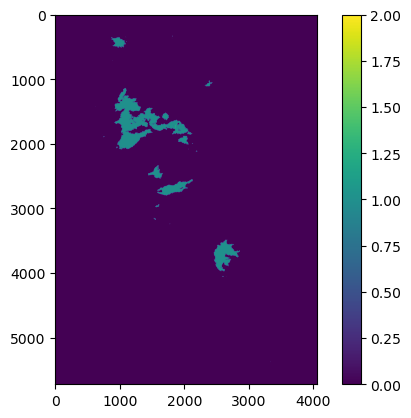

In [10]:
# utility lines
utility_layer = folium.GeoJson(utility_df, name="Transmission Lines")

# Folium Heatmap (unused but here's the code)
"""
ignition_df['LATITUDE'] = ignition_df.geometry.y
ignition_df['LONGITUDE'] = ignition_df.geometry.x
ignition_coords = ignition_df[['LATITUDE', 'LONGITUDE']].values.tolist()
ignition_heatmap_layer = HeatMap(ignition_coords, name="Ignition Points")
"""

# Heatmaps with Vector To Heatmap Overlay Function
perimeter_heatmap = vector_to_heatmap_overlay(perimeter_df['geometry'], "Fire Perimeters")
ignition_heatmap = vector_to_heatmap_overlay(buffered_ignition, "Fire Ignition Points")
sn_raster = vector_to_heatmap_overlay([SN_SHAPE], "Sierra Nevada Raster", cmap_name='viridis')

# save all to list
fire_utility_layers = [utility_layer, perimeter_heatmap, ignition_heatmap, sn_raster]

In [96]:
# save all to list
fire_utility_layers = [utility_layer, perimeter_heatmap, ignition_heatmap, sn_raster]

# Geoserver Layers
RRK link: https://rrk.sdsc.edu/sierra.html

Geoserver Link: https://sparcal.sdsc.edu/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?0&filter=false

In [81]:
carbon_layers = []
carbon_layer_info = {'Dead Carbon':'rrk_sn:DeadCarbon_2021',
                     'Total Carbon':'rrk_sn:CECS_TotalCarbon_30m',
                     'Aboveground Live Tree Carbon':'rrk_sn:F3_AbovegroundLiveTreeCarbon_2021',
                     'Total Aboveground Carbon':'rrk_sn:CECS_TotalCarbon_30m'}
for layer_name in carbon_layer_info:
    layer = WmsTileLayer(url=GEOSERVER_URL,
                         layers=carbon_layer_info[layer_name],
                         name=layer_name,
                         transparent=True,
                         overlay=True,
                         control=True,
                         fmt="image/png8",
                         tiled=True,
                         opacity=0.5)
    carbon_layers.append(layer)

# The Map

In [20]:
center = SN_SHAPE.centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, tiles="CartoDB Positron", zoom_start=8)

layers = carbon_layers + fire_utility_layers

for layer in layers:
    layer.add_to(m)

folium.GeoJson(SN_SHAPE, name="Sierra Nevada Region").add_to(m)
folium.LayerControl().add_to(m)

NameError: name 'carbon_layers' is not defined

# I'm Experimenting here:

In [3]:
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer

In [49]:
METERS_PER_UNIT_CRS = 2

def vector_to_heatmap_overlay(geoms: gpd.GeoSeries, layer_name: str, aoi_geom: gpd.GeoSeries = SN_SHAPE, cmap_name='hot', pixel_size=300):
    crs_for_resolution = 'EPSG:5070'
    crs_for_display = 'EPSG:4326'

    # create transform in EPSG:5070 for resolution
    minx, miny, maxx, maxy = aoi_geom.to_crs(crs_for_resolution)[0].bounds
    width_raw = maxx - minx
    height_raw = maxy - miny
    width_for_resolution = int(width_raw * METERS_PER_UNIT_CRS / pixel_size)
    height_for_resolution = int(height_raw * METERS_PER_UNIT_CRS / pixel_size)
    trans_for_resolution = rasterio.transform.from_bounds(minx, miny, maxx, maxy, 
                                                          width_for_resolution, height_for_resolution)
    print("EPSG:5070 Transform")
    print("width:", width_for_resolution,", height:", height_for_resolution, f", {pixel_size} meters per pixel")

    # create transform in EPSG:4326 for display
    (trans_for_display, 
     width_for_display, 
     height_for_display) = calculate_default_transform(crs_for_resolution, crs_for_display, 
                                                       width_for_resolution, height_for_resolution, 
                                                       *trans_for_resolution * (0, 0), 
                                                       *trans_for_resolution * (width_for_resolution, height_for_resolution))
    print("\nEPSG:4326 Transform")
    print("width:", width_for_display,", height:", height_for_display)

    # Generate Heatmap Data in EPSG:4326
    data = np.zeros((height_for_display, width_for_display))
    for geom in tqdm(geoms.to_crs(crs_for_display)): # ensure geoms are in EPSG:4326
        rasterized_geom = rasterize(shapes=[(geom, 1)], fill=0, 
                                    transform=trans_for_display, 
                                    out_shape=(height_for_display, width_for_display), 
                                    all_touched=True)
        data += rasterized_geom
    
    # create image
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize(vmin=data.min(), vmax=data.max())
    image_data = cmap(norm(data))
    alpha_channel = np.where(data > 0, 255, 0)
    rgba_image_data = np.dstack((image_data[:, :, :3] * 255, alpha_channel)).astype(np.uint8)
    image = Image.fromarray(rgba_image_data, 'RGBA')
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmp_file:
        image.save(tmp_file.name, format='PNG')
        tmp_file_path = tmp_file.name

    # sanity check
    loaded_image = Image.open(tmp_file_path)
    fig, ax = plt.subplots()
    im = ax.imshow(loaded_image)
    aoi_geom.plot(ax=ax, alpha=0.5)
    plt.axis('off')  # Hide axes
    plt.show()

    # create layer
    minx, miny = trans_for_display * (0, height_for_display)
    maxx, maxy = trans_for_display * (width_for_display, 0)
    
    img_overlay = ImageOverlay(
        name=layer_name,
        image=tmp_file_path,
        bounds=[[miny, minx], [maxy, maxx]],
        opacity=0.5,
        transparent=True,
        overlay=True,
        control=True,
        fmt="image/png8",
        tiled=True,
    )
    return img_overlay

EPSG:5070 Transform
width: 1831 , height: 5451 , 300 meters per pixel

EPSG:4326 Transform
width: 4059 , height: 5725


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


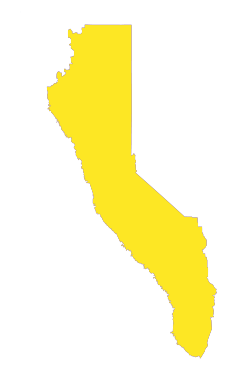

In [50]:
center = SN_SHAPE[0].centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, tiles="CartoDB Positron", zoom_start=8)
vector_to_heatmap_overlay(SN_SHAPE, "Sierra Nevada Raster", cmap_name='viridis').add_to(m)
folium.GeoJson(SN_SHAPE, name="Sierra Nevada Region").add_to(m)
folium.LayerControl().add_to(m)


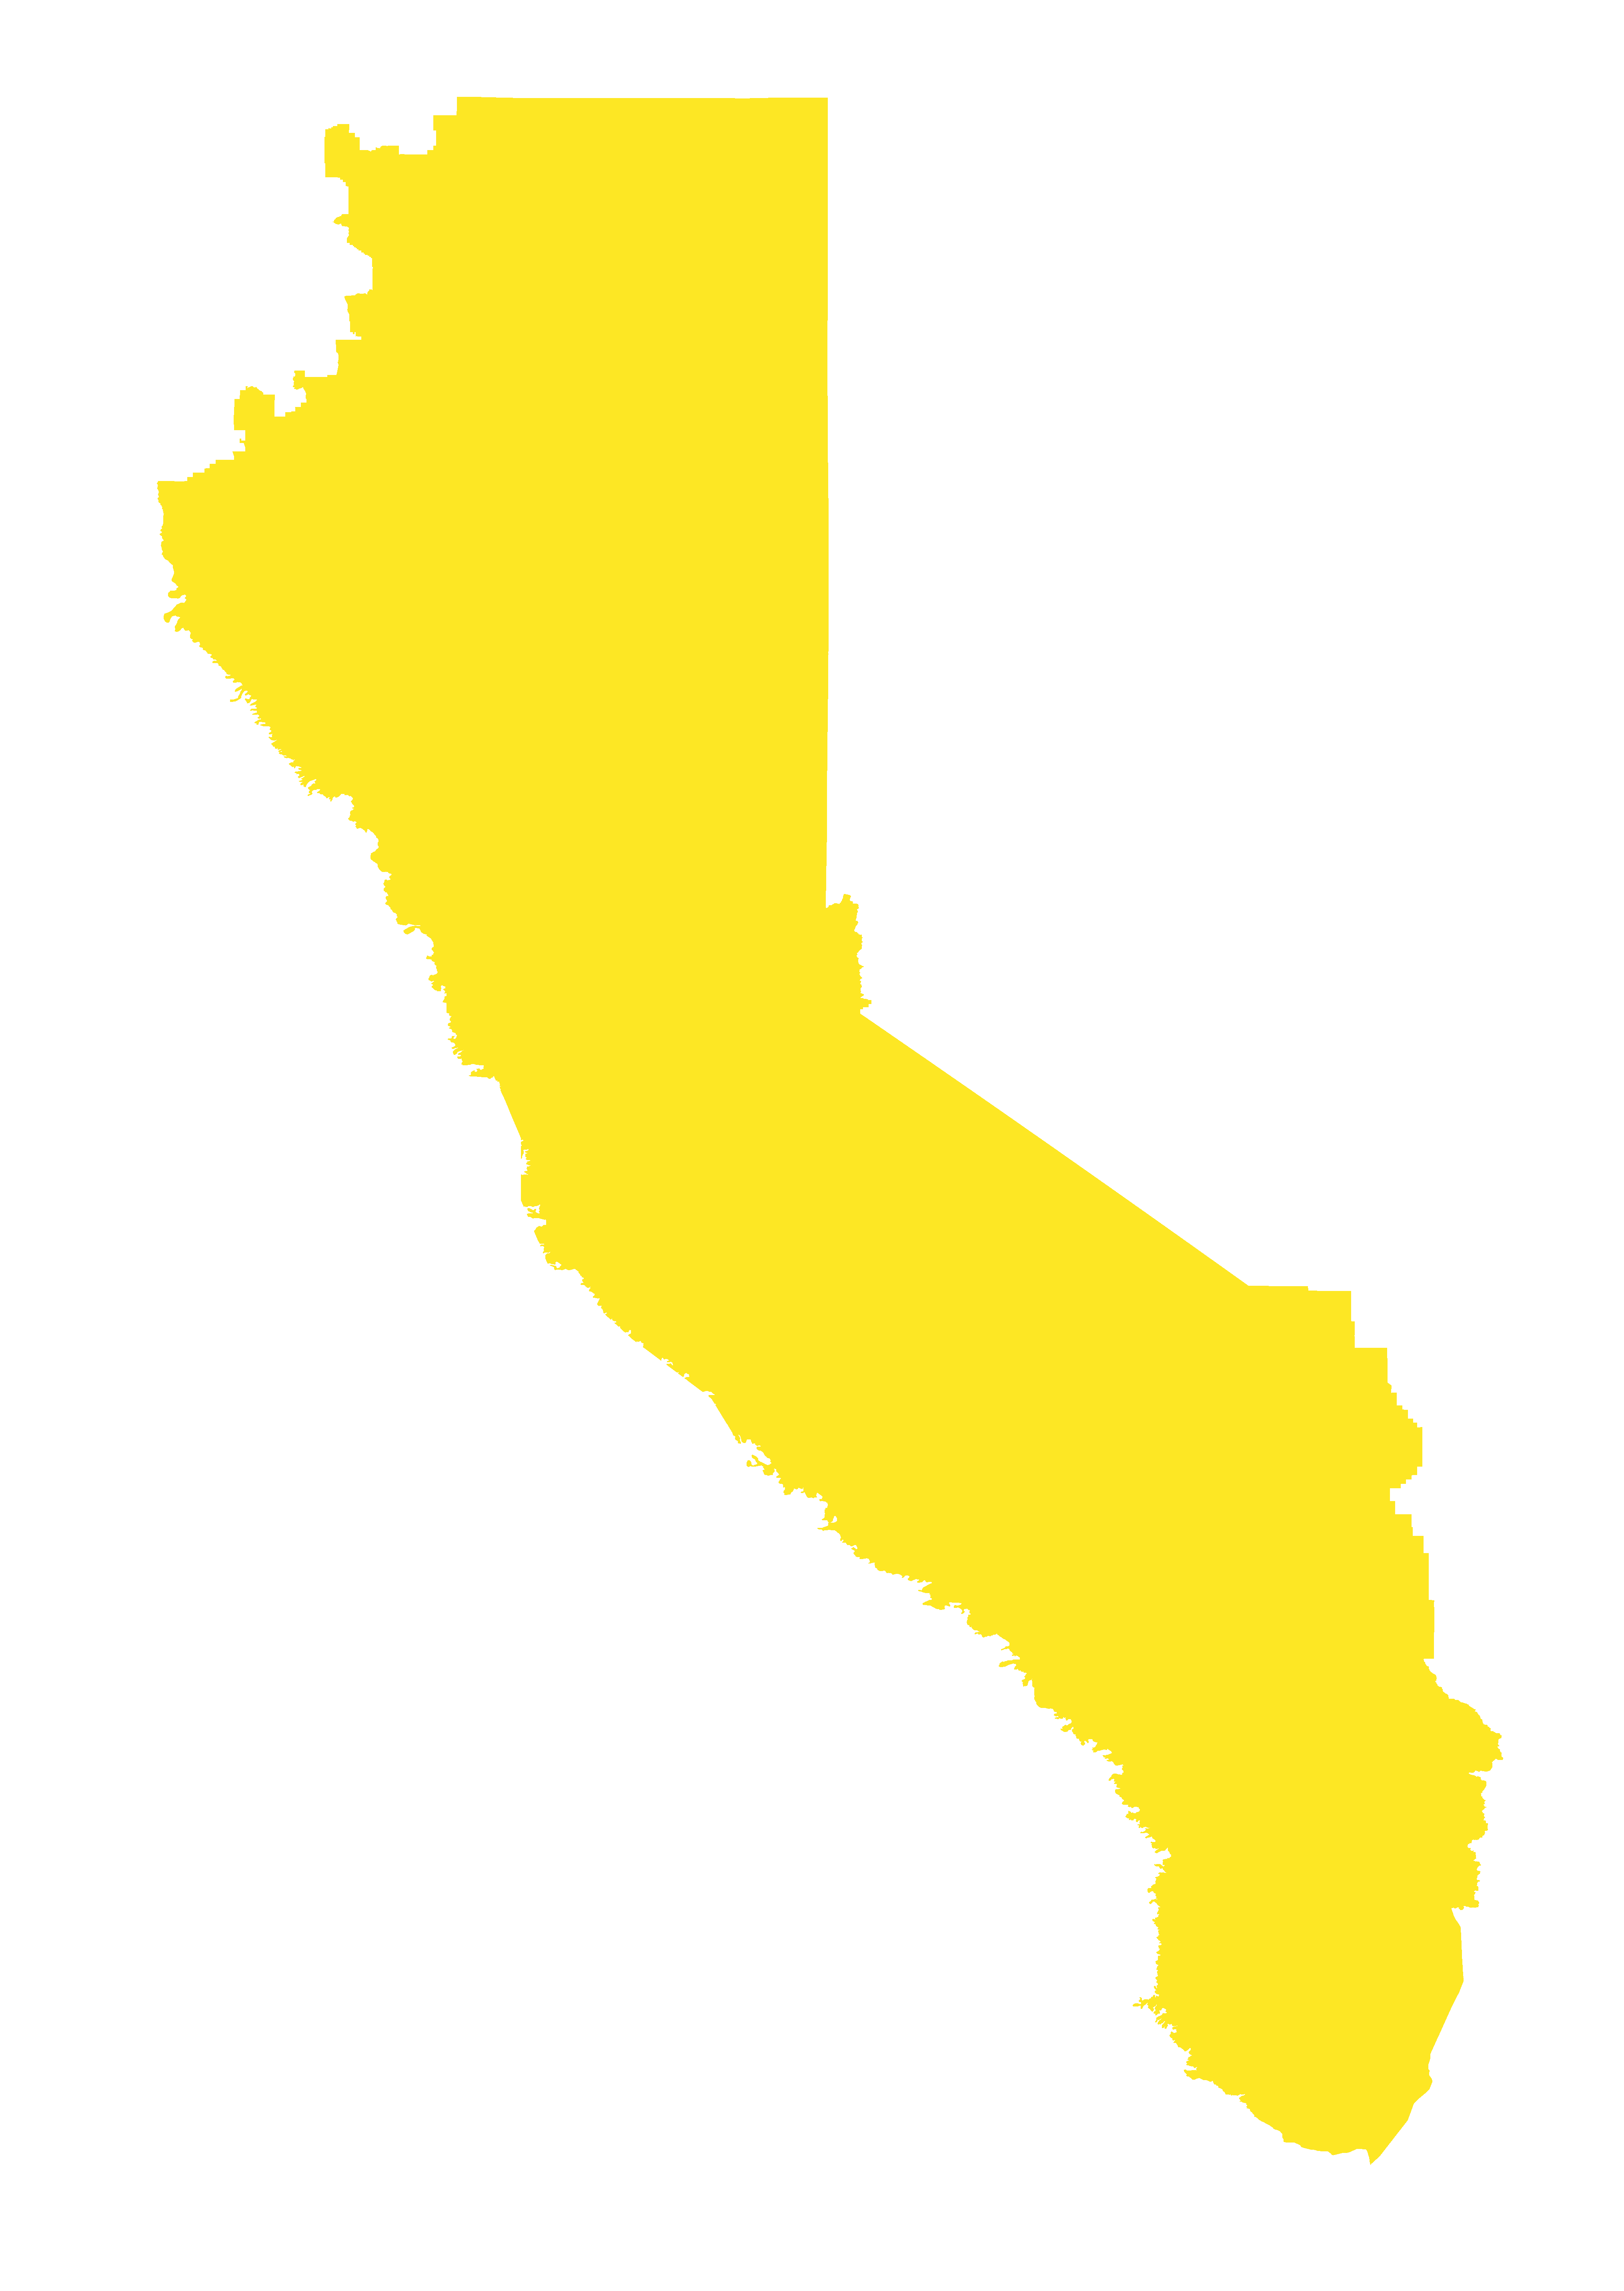

In [51]:
m

In [86]:
SN_SHAPE.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# DEFUNCT approach to rasterization (misalignment)
minx, miny, maxx, maxy = SN_SHAPE[0].bounds
width_raw = maxx - minx
height_raw = maxy - miny
width = int(width_raw * 200)
height = int(height_raw * 200)
trans = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)
data = rasterize(shapes=[(SN_SHAPE[0], 1)], fill=0, 
                 transform=trans, 
                 out_shape=(height, width), 
                 all_touched=False,
                 dtype='uint8')

In [67]:
from osgeo import gdal, ogr, osr

In [96]:
import numpy as np
from shapely.geometry import Polygon
from osgeo import gdal, ogr
from PIL import Image
import folium
import tempfile
import geopandas as gpd

SN_SHAPE = gpd.read_file(SN_SHAPE_PATH).to_crs(epsg=4326)['geometry']

ogr_polygon = ogr.CreateGeometryFromWkb(SN_SHAPE[0].wkb)

# Create an in-memory OGR layer to hold the polygon
driver = ogr.GetDriverByName('Memory')
datasource = driver.CreateDataSource('memData')
layer = datasource.CreateLayer('layer', geom_type=ogr.wkbPolygon)

# Create a field and add it to the layer
field = ogr.FieldDefn('id', ogr.OFTInteger)
layer.CreateField(field)

# Create a feature and set the geometry
feature = ogr.Feature(layer.GetLayerDefn())
feature.SetGeometry(ogr_polygon)
feature.SetField('id', 1)
layer.CreateFeature(feature)

# Define the raster size and geotransformation
pixel_size = 0.01  # Define the pixel size
minx, miny, maxx, maxy = SN_SHAPE[0].bounds

# Adjust bounds to align with the raster grid
aligned_minx = np.floor(minx - (minx % pixel_size))
aligned_miny = np.floor(miny - (miny % pixel_size))
aligned_maxx = np.ceil(maxx + (pixel_size - (maxx % pixel_size)))
aligned_maxy = np.ceil(maxy + (pixel_size - (maxy % pixel_size)))

# Update raster resolution based on adjusted bounds
x_res = int((aligned_maxx - aligned_minx) / pixel_size)
y_res = int((aligned_maxy - aligned_miny) / pixel_size)

# Create a raster in memory
target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((aligned_minx, pixel_size, 0, aligned_maxy, 0, -pixel_size))

# Create a band to write the data to
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(0)
band.Fill(0)

# Rasterize the polygon layer
gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[1], options=["ALL_TOUCHED=TRUE"])

# Read the raster data as a numpy array
data = band.ReadAsArray()

# Clean up and close the datasets
band = None
target_ds = None
layer = None
datasource = None

# create image
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=data.min(), vmax=data.max())
image_data = cmap(norm(data))
alpha_channel = np.where(data > 0, 255, 0)
rgba_image_data = np.dstack((image_data[:, :, :3] * 255, alpha_channel)).astype(np.uint8)
image = Image.fromarray(rgba_image_data, 'RGBA')
with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmp_file:
    image.save(tmp_file.name, format='PNG')
    tmp_file_path = tmp_file.name

# create image overlay
bounds = [[aligned_miny, aligned_minx], [aligned_maxy, aligned_maxx]]
img_overlay = ImageOverlay(
    name="please work",
    image=tmp_file_path,
    bounds=bounds,
    opacity=0.5,
    transparent=True,
    overlay=True,
    control=True,
    fmt="image/png8",
    tiled=True,
    interactive=True,
    cross_origin=False,
    zindex=1
)
# create folium map
center = SN_SHAPE[0].centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, tiles="CartoDB Positron", zoom_start=8)

# add new image overlay
img_overlay.add_to(m)

# add original polygon
folium.GeoJson(SN_SHAPE, name="Sierra Nevada Region").add_to(m)
folium.LayerControl().add_to(m)

m

Warning 1: Failed to fetch spatial reference on layer layer to build transformer, assuming matching coordinate systems.


In [97]:
center = SN_SHAPE[0].centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, tiles="CartoDB Positron", zoom_start=8)
img_overlay.add_to(m)
folium.GeoJson(SN_SHAPE, name="Sierra Nevada Region").add_to(m)
folium.LayerControl().add_to(m)


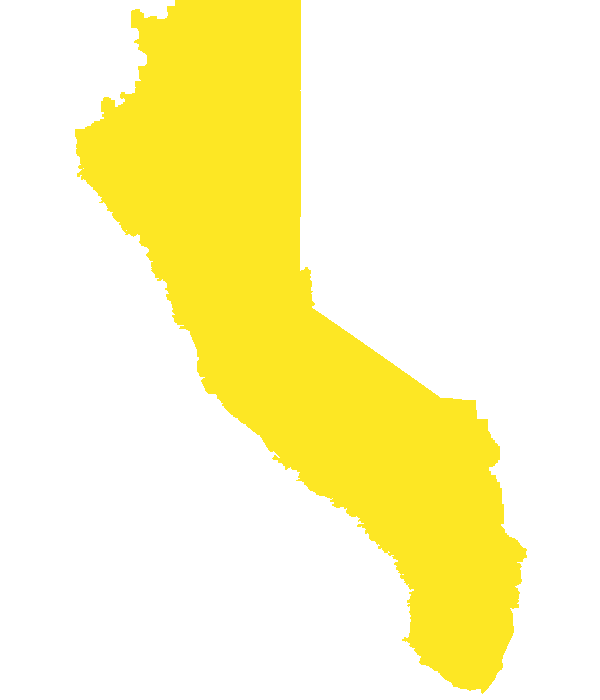

In [98]:
m